<a href="https://colab.research.google.com/github/kywch/geo-colab/blob/master/SafeGraph-social-distancing-visualize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
colab_requirements = [
    "apt install python3-rtree=0.8.3+ds-1", # rtree v0.8.3
    "pip install git+git://github.com/geopandas/geopandas.git@032bcbebf86fd8cae2870097e850e8427c861644", # geopandas v0.7.0
]

In [0]:
# following the post, 'Making Jupyter notebooks Google Colab ready'
# https://timsainburg.com/google%20colab.html

import os, sys, subprocess

def run_subprocess_command(cmd):
    # run the command
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    # print the output
    for line in process.stdout:
        print(line.decode().strip())
        
if 'COLAB_GPU' in os.environ: # a quick and dirty way to check whether this is COLAB
    for i in colab_requirements:
        run_subprocess_command(i)

Reading package lists...
Building dependency tree...
Reading state information...
python3-rtree is already the newest version (0.8.3+ds-1).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.
Cloning git://github.com/geopandas/geopandas.git (to revision 032bcbebf86fd8cae2870097e850e8427c861644) to /tmp/pip-req-build-dtnnt_65
Created wheel for geopandas: filename=geopandas-0.7.0-py2.py3-none-any.whl size=928057 sha256=f72d8cdcc098f5bb602168cbbfcead7082655d667937e8e86235cedc15c2ab9f
Stored in directory: /tmp/pip-ephem-wheel-cache-m1iqfum5/wheels/a6/7b/d1/832d980d877822f82fa08859a15398c754b74e7a49512ad22d
Successfully built geopandas


In [0]:
import pandas as pd
import geopandas as gpd

from fiona.crs import from_epsg
from shapely.geometry import Point

from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.units as munits

## Get the census block groups of Chicago

In [0]:
cook_cbg = gpd.read_file('https://raw.githubusercontent.com/loganpowell/census-geojson/master/GeoJSON/500k/2019/17/block-group.json', 
                   crs = from_epsg(2163)).to_crs(epsg = 3528)
# select Cook county
cook_cbg = cook_cbg[cook_cbg.COUNTYFP == '031']
cook_cbg = cook_cbg[['GEOID', 'geometry']]
cook_cbg.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3992 entries, 0 to 9688
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   GEOID     3992 non-null   object  
 1   geometry  3992 non-null   geometry
dtypes: geometry(1), object(1)
memory usage: 93.6+ KB


In [0]:
chi_bound = gpd.read_file('https://data.cityofchicago.org/api/geospatial/ewy2-6yfk?method=export&format=GeoJSON', 
                   crs = from_epsg(2163)).to_crs(epsg = 3528)

In [0]:
chi_cbg = gpd.sjoin(cook_cbg, chi_bound,
                    op='intersects').drop("index_right", axis = 1)
chi_cbg.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2325 entries, 0 to 9685
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   GEOID       2325 non-null   object  
 1   geometry    2325 non-null   geometry
 2   name        2325 non-null   object  
 3   objectid    2325 non-null   object  
 4   shape_area  2325 non-null   object  
 5   shape_len   2325 non-null   object  
dtypes: geometry(1), object(5)
memory usage: 127.1+ KB


## Visualizing the values across time

In [0]:
# upload the processed file from the local computer
from google.colab import files
uploaded = files.upload()

Saving social_distancing_17031.csv.gz to social_distancing_17031.csv (1).gz


In [0]:
# check if the file has been successfully uploaded
!ls

 sample_data		      'social_distancing_17031.csv (1).gz'
 social_distancing_17031.csv   social_distancing_17031.csv.gz


In [0]:
socdist_df = pd.read_csv('social_distancing_17031.csv.gz')

In [0]:
socdist_df['date'] = socdist_df.date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
socdist_df['weekday'] = socdist_df.date.apply(lambda x: x.weekday())
socdist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1186394 entries, 0 to 1186393
Data columns (total 12 columns):
 #   Column                       Non-Null Count    Dtype         
---  ------                       --------------    -----         
 0   origin_census_block_group    1186394 non-null  int64         
 1   date                         1186394 non-null  datetime64[ns]
 2   device_count                 1186394 non-null  int64         
 3   distance_traveled_from_home  1186378 non-null  float64       
 4   p_completely_home            1186394 non-null  float64       
 5   p_lt_6h_out                  1186394 non-null  float64       
 6   p_6h_12h_out                 1186394 non-null  float64       
 7   p_ht_12h_out                 1186394 non-null  float64       
 8   p_part_time_work             1186394 non-null  float64       
 9   p_full_time_work             1186394 non-null  float64       
 10  p_delivery                   1186394 non-null  float64       
 11  weekday    

### The number of devices being tracked

In [0]:
dev_cnt = socdist_df.groupby("date").sum()[['device_count']]
dev_cnt.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 512 entries, 2019-01-01 to 2020-05-26
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   device_count  512 non-null    int64
dtypes: int64(1)
memory usage: 8.0 KB


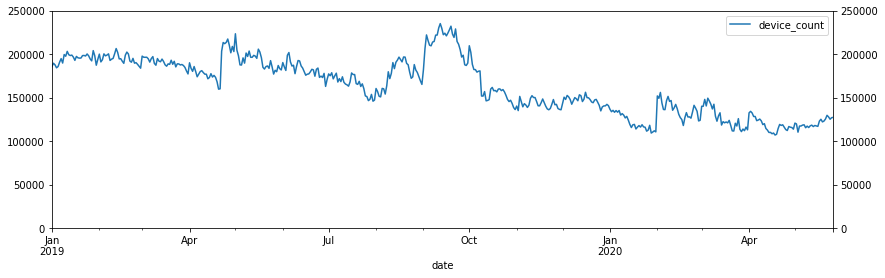

In [0]:
ax = dev_cnt.plot(figsize = (14,4), ylim = (0,250000))
ax.tick_params(labelright=True, right=True)

### Work-related variables across time

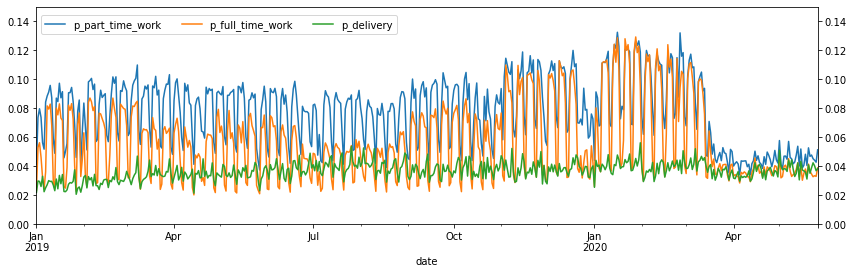

In [0]:
prob_summ = socdist_df.groupby("date").mean()

ax = prob_summ[['p_part_time_work', 'p_full_time_work', 'p_delivery']].plot(legend = True, figsize = (14,4), ylim = (0,.15))
ax.tick_params(labelright = True, right=True)
ax.legend(loc='lower left', bbox_to_anchor=(0., .85, 1., .102), ncol=3)

### Stay-home related variables

* `p_completely_home`: Proportion of the 'devices' that did not leave the 153m x 153m home grid.
* `p_lt_6h_out`: Proportion of the devices that spent less than 6 hours outside the home grid.
* `p_6h_12h_out`: Proportion of the devices that spent 6-12 hours outside the home grid. *Perhaps reflecting full-time work.*
* `p_ht_12h_out`: Proportion of the devices that spent more than 12 hours outside the home grid. *Seems somewhat stable.*

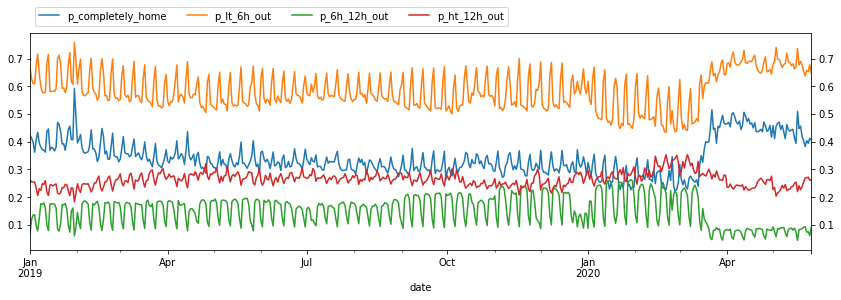

In [0]:
ax = prob_summ[['p_completely_home', 'p_lt_6h_out', 'p_6h_12h_out', 'p_ht_12h_out']].plot(legend = True, figsize = (14,4))
ax.tick_params(labelright = True, right=True)
ax.legend(loc='lower left', bbox_to_anchor=(0., 1.01, 1., .102), ncol=4)

### Comparing 2019 weekday pattern vs. after lock-down

In [0]:
# weekday: Monday(0) - Sunday(6)

# 2019 all around
weekday_2019 = socdist_df[socdist_df.date < '01-01-2020'].groupby('weekday').mean()

# 2020-01-01 to 2020-03-15
weekday_2020_before = socdist_df[(socdist_df.date > '12-31-2019') & (socdist_df.date < '03-16-2020')].groupby('weekday').mean()

# 2020-04-01 and after
weekday_2020_after = socdist_df[(socdist_df.date > '03-31-2020')].groupby('weekday').mean()

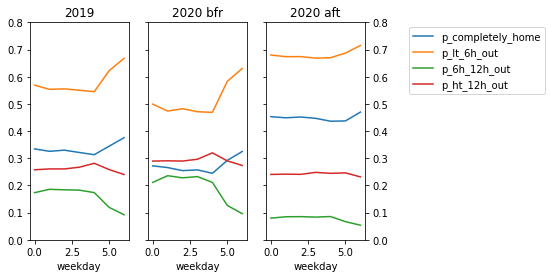

In [0]:
selected_columns = ['p_completely_home', 'p_lt_6h_out', 'p_6h_12h_out', 'p_ht_12h_out']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (6,4) )

weekday_2019[selected_columns].plot(ylim = (0,.8),  ax=axes[0], legend=False, title = '2019')
weekday_2020_before[selected_columns].plot(ylim = (0,.8), sharey=True, ax=axes[1], legend=False, title = '2020 bfr')
ax = weekday_2020_after[selected_columns].plot(ylim = (0,.8), sharey=True, ax=axes[2], title = '2020 aft')
ax.tick_params(labelright = True, right=True)

# https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot
ax.legend(loc='upper left', bbox_to_anchor=(1.4, 1))

### Visualizing the spatial patterns

In [0]:
# 2019 all around
cbg_mean_2019 = socdist_df[(socdist_df.date < '01-01-2020')].groupby('origin_census_block_group').mean()
cbg_mean_2019 = cbg_mean_2019.reset_index()
cbg_mean_2019['GEOID'] = cbg_mean_2019.origin_census_block_group.astype('str')

# 2020-01-01 to 2020-03-15
cbg_mean_2020_before = socdist_df[(socdist_df.date > '12-31-2019') & (socdist_df.date < '03-16-2020')].groupby('origin_census_block_group').mean()
cbg_mean_2020_before = cbg_mean_2020_before.reset_index()
cbg_mean_2020_before['GEOID'] = cbg_mean_2020_before.origin_census_block_group.astype('str')

# 2020-04-01 and after
cbg_mean_2020_after = socdist_df[(socdist_df.date > '03-31-2020')].groupby('origin_census_block_group').mean()
cbg_mean_2020_after = cbg_mean_2020_after.reset_index()
cbg_mean_2020_after['GEOID'] = cbg_mean_2020_after.origin_census_block_group.astype('str')

In [0]:
# divide by the mean to get the overall distribution
selected_columns = ['p_completely_home', 'p_lt_6h_out', 'p_6h_12h_out', 'p_ht_12h_out']

# r_*: each census block group divided by the mean of all CBGs
# z_*: z-scored CBG values
for col in selected_columns:
    cbg_mean_2019['r_' + col] = cbg_mean_2019[col] / cbg_mean_2019[col].mean()
    cbg_mean_2019['z_' + col] = (cbg_mean_2019[col] - cbg_mean_2019[col].mean()) / cbg_mean_2019[col].std()
    
    cbg_mean_2020_before['r_' + col] = cbg_mean_2020_before[col] / cbg_mean_2020_before[col].mean()
    cbg_mean_2020_before['z_' + col] = (cbg_mean_2020_before[col] - cbg_mean_2020_before[col].mean()) / cbg_mean_2020_before[col].std()
    
    cbg_mean_2020_after['r_' + col] = cbg_mean_2020_after[col] / cbg_mean_2020_after[col].mean()
    cbg_mean_2020_after['z_' + col] = (cbg_mean_2020_after[col] - cbg_mean_2020_after[col].mean()) / cbg_mean_2020_after[col].std()

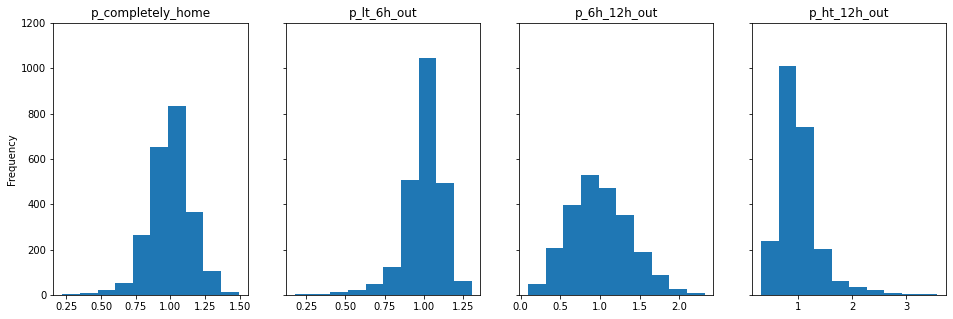

In [0]:
fix, ax = plt.subplots(1,len(selected_columns), figsize=(16,5))
for ii in range(len(selected_columns)):
    cbg_mean_2020_after['r_' + selected_columns[ii]].\
      plot(kind='hist', ylim = (0,1200), sharey=True, ax = ax[ii], title=selected_columns[ii])


In [0]:
# prepare for mapping
cbg_gdf_2019 = pd.merge(chi_cbg, cbg_mean_2019, 
                       left_on = "GEOID", right_on = "GEOID", 
                       how = "right")

cbg_gdf_2020_before = pd.merge(chi_cbg, cbg_mean_2020_before, 
                       left_on = "GEOID", right_on = "GEOID", 
                       how = "right")

cbg_gdf_2020_after = pd.merge(chi_cbg, cbg_mean_2020_after, 
                       left_on = "GEOID", right_on = "GEOID", 
                       how = "right")

### The proportion of completely_home

* Scaled from 0.2 (blue) - 0.6 (red)
* The 2019 map seems to follow the socio-economic status

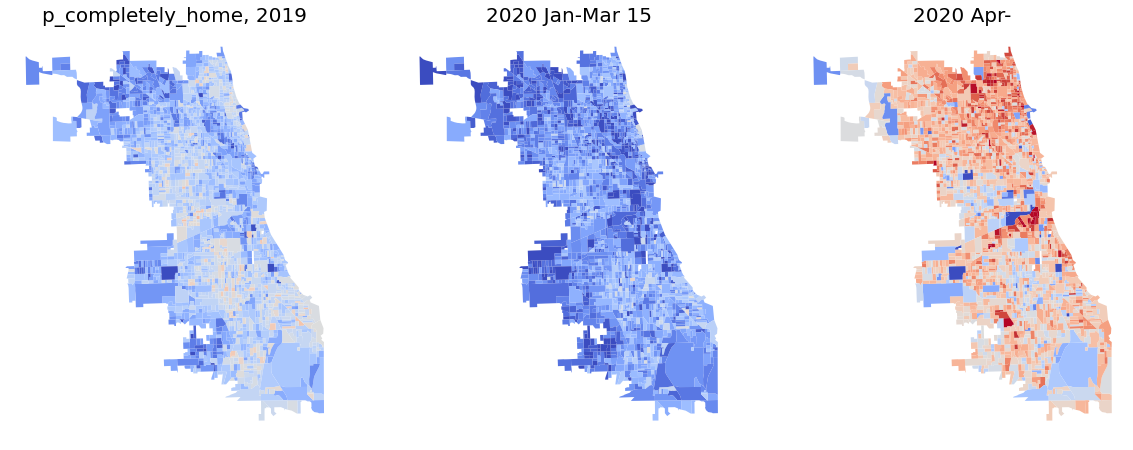

In [0]:
fig, ax = plt.subplots(1,3, figsize=(20,14))

ii = 0
ij = 0

year = ['2019', '2020 Jan-Mar 15', '2020 Apr-']

for gdf in [cbg_gdf_2019, cbg_gdf_2020_before, cbg_gdf_2020_after]:
    bx = gdf.plot(column = selected_columns[ii], 
        vmin = 0.2, vmax = 0.6, cmap = "coolwarm", ax = ax[ij])
   
    if (ij == 0):
        bx.set_title(selected_columns[ii] + ', ' + year[ij], fontsize=20)
    else:
        bx.set_title(year[ij], fontsize=20)
    bx.xaxis.set_major_locator(plt.NullLocator())
    bx.yaxis.set_major_locator(plt.NullLocator())
    bx.set_axis_off()
    bx.set_axis_on()
    for a in ["bottom", "top", "right", "left"]:
        bx.spines[a].set_linewidth(0)
    ij += 1

### The proportion of less than 6-hour outside home

* Scaled from 0.4 (blue) - 0.8 (red)
* The 2019 map seems to follow the socio-economic status

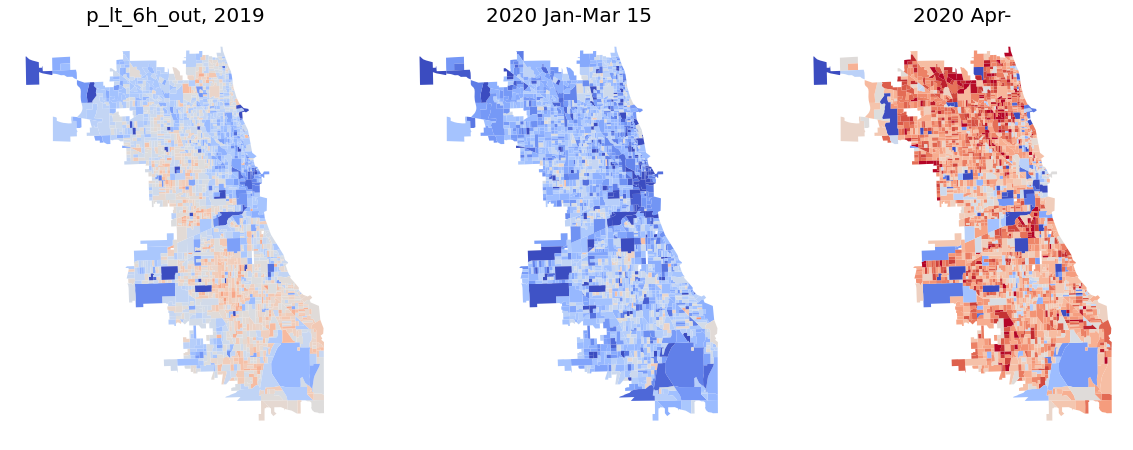

In [0]:
fig, ax = plt.subplots(1,3, figsize=(20,12))

ii = 1
ij = 0

year = ['2019', '2020 Jan-Mar 15', '2020 Apr-']

for gdf in [cbg_gdf_2019, cbg_gdf_2020_before, cbg_gdf_2020_after]:
    bx = gdf.plot(column = selected_columns[ii], 
        vmin = 0.4, vmax = 0.8, cmap = "coolwarm", ax = ax[ij])
   
    if (ij == 0):
        bx.set_title(selected_columns[ii] + ', ' + year[ij], fontsize=20)
    else:
        bx.set_title(year[ij], fontsize=20)
    bx.xaxis.set_major_locator(plt.NullLocator())
    bx.yaxis.set_major_locator(plt.NullLocator())
    bx.set_axis_off()
    bx.set_axis_on()
    for a in ["bottom", "top", "right", "left"]:
        bx.spines[a].set_linewidth(0)
    ij += 1


### The proportion of 6-12 hours outside home

* Scaled from 0.0 (blue) - 0.3 (red)
* The pre-corona map seems to resemble full-time employment?

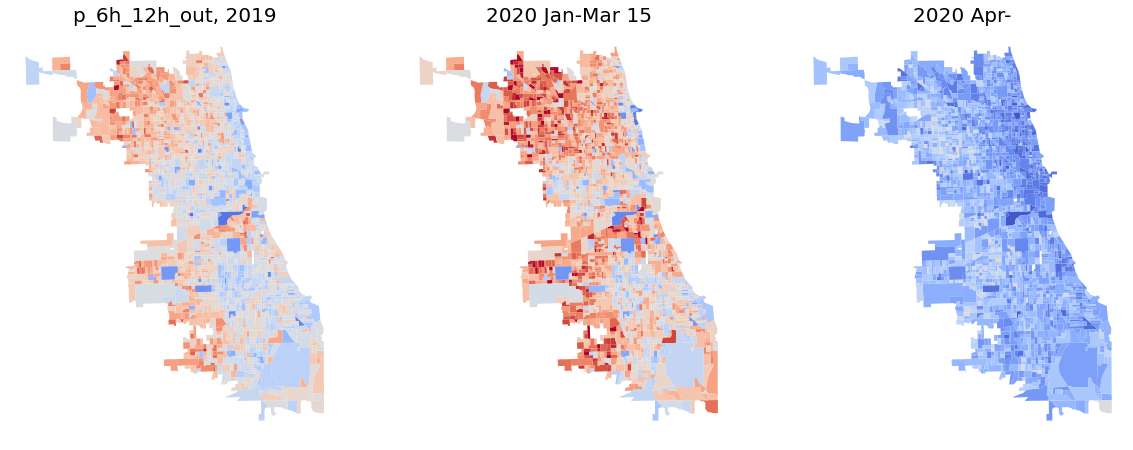

In [0]:
fig, ax = plt.subplots(1,3, figsize=(20,12))

ii = 2
ij = 0

year = ['2019', '2020 Jan-Mar 15', '2020 Apr-']

for gdf in [cbg_gdf_2019, cbg_gdf_2020_before, cbg_gdf_2020_after]:
    bx = gdf.plot(column = selected_columns[ii], 
        vmin = 0.0, vmax = 0.3, cmap = "coolwarm", ax = ax[ij])
   
    if (ij == 0):
        bx.set_title(selected_columns[ii] + ', ' + year[ij], fontsize=20)
    else:
        bx.set_title(year[ij], fontsize=20)
    bx.xaxis.set_major_locator(plt.NullLocator())
    bx.yaxis.set_major_locator(plt.NullLocator())
    bx.set_axis_off()
    bx.set_axis_on()
    for a in ["bottom", "top", "right", "left"]:
        bx.spines[a].set_linewidth(0)
    ij += 1

### The proportion of 12-24 hours outside home

* Scaled from 0.1 (blue) - 0.6 (red)
* Red regions include airport, medical districts, etc?

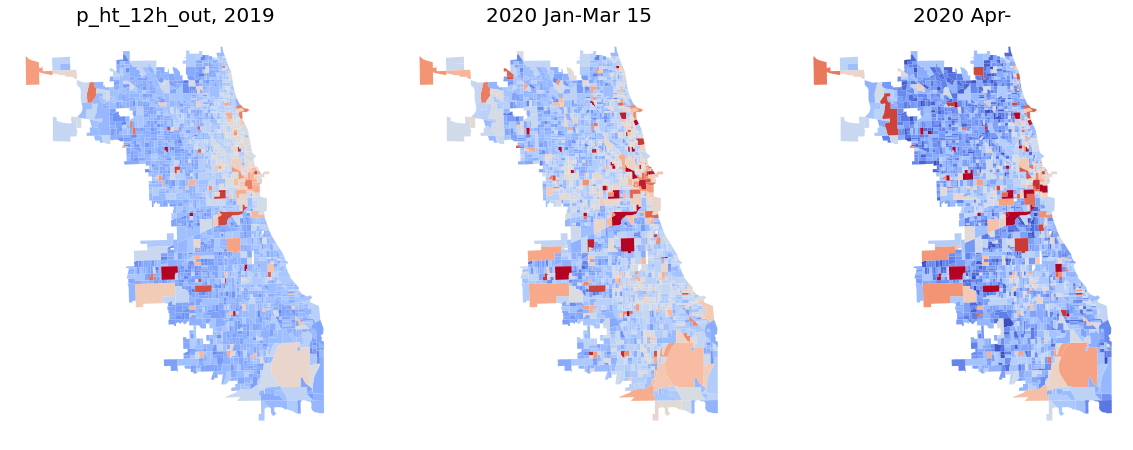

In [0]:
fig, ax = plt.subplots(1,3, figsize=(20,12))

ii = 3
ij = 0

year = ['2019', '2020 Jan-Mar 15', '2020 Apr-']

for gdf in [cbg_gdf_2019, cbg_gdf_2020_before, cbg_gdf_2020_after]:
    bx = gdf.plot(column = selected_columns[ii], 
        vmin = 0.1, vmax = 0.6, cmap = "coolwarm", ax = ax[ij])
   
    if (ij == 0):
        bx.set_title(selected_columns[ii] + ', ' + year[ij], fontsize=20)
    else:
        bx.set_title(year[ij], fontsize=20)
    bx.xaxis.set_major_locator(plt.NullLocator())
    bx.yaxis.set_major_locator(plt.NullLocator())
    bx.set_axis_off()
    bx.set_axis_on()
    for a in ["bottom", "top", "right", "left"]:
        bx.spines[a].set_linewidth(0)
    ij += 1